In [96]:

pip install tensorflow matplotlib numpy scipy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2


2025-06-18 07:42:50.833007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 07:42:50.833903: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 07:42:50.837338: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 07:42:50.846526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750232570.860307 2027036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750232570.86

In [121]:
# Dataset folder structure:
# dataset/
# ├── normal/
# └── sakit/

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,          # lebih besar
    width_shift_range=0.2,      # lebih besar
    height_shift_range=0.2,     # lebih besar
    shear_range=0.2,            # lebih besar
    zoom_range=0.2,             # lebih besar
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    'dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)
val_gen = val_datagen.flow_from_directory(
    'dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

# Lihat label
print("Label klasifikasi otomatis:", train_gen.class_indices)


Found 389 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Label klasifikasi otomatis: {'normal': 0, 'sakit': 1}


In [122]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # more units + L2
    layers.Dropout(0.4),  # higher dropout
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ...existing code...


# ...existing code...

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [123]:

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_gen.classes),
#     y=train_gen.classes
# )
# class_weights = dict(enumerate(class_weights))


history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop],
    # class_weight=class_weights
)


/home/ubuntu/machine-learning/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5470 - loss: 1.0542 - val_accuracy: 0.6250 - val_loss: 0.9587
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6023 - loss: 1.0149 - val_accuracy: 0.6250 - val_loss: 0.9629
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6458 - loss: 0.9389 - val_accuracy: 0.6250 - val_loss: 0.9622
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 978ms/step - accuracy: 0.6558 - loss: 0.9298 - val_accuracy: 0.5938 - val_loss: 0.9649
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7125 - loss: 0.8573 - val_accuracy: 0.6042 - val_loss: 0.9676


In [124]:
model.save('ctscan_model.h5')

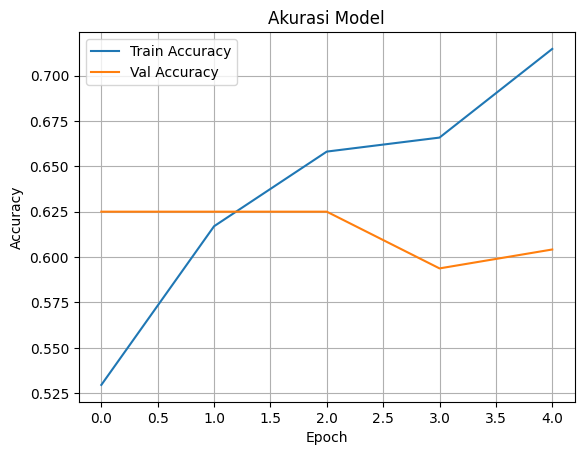

In [125]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


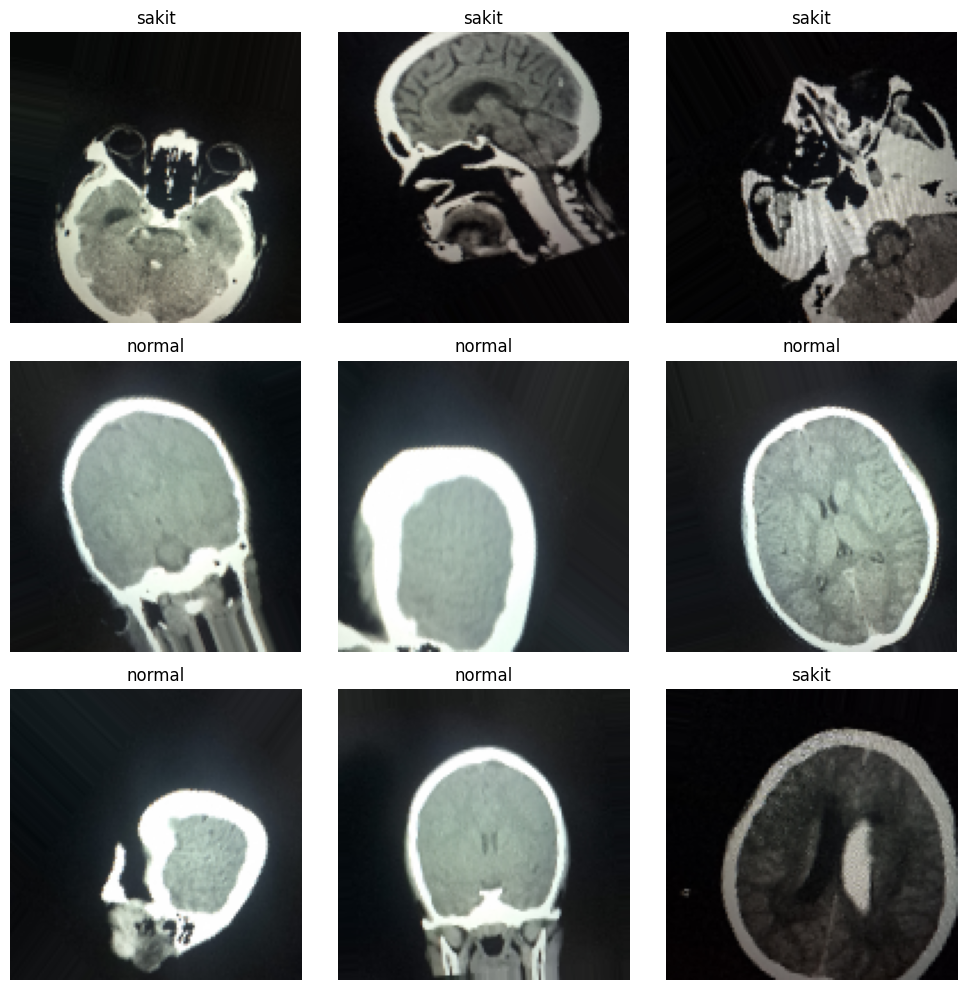

In [126]:
# Menampilkan contoh batch gambar dari train_gen beserta labelnya

images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = "sakit" if labels[i] > 0.5 else "normal"
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:

loaded_model = load_model('ctscan_model.h5')

# Improved prediction function
def predict_image(img_path):
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = loaded_model.predict(img_array)[0][0]
    print("Raw prediction value:", prediction)
    # Swap the label assignment here:
    label = "sakit" if prediction > 0.5 else "normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Gambar: {os.path.basename(img_path)}")
    print(f"Prediksi: {label} (confidence: {confidence:.2f})")
    plt.imshow(img)
    plt.title(f"{label} - {confidence:.2f}")
    plt.axis('off')
    plt.show()



2025-06-18 07:42:58.321052: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Raw prediction value: 0.6632198
Gambar: 20250602_150807.jpg
Prediksi: sakit (confidence: 0.66)


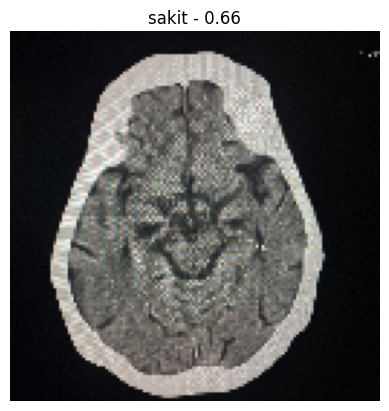

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Raw prediction value: 0.42231867
Gambar: 20250616_145956.jpg
Prediksi: normal (confidence: 0.58)


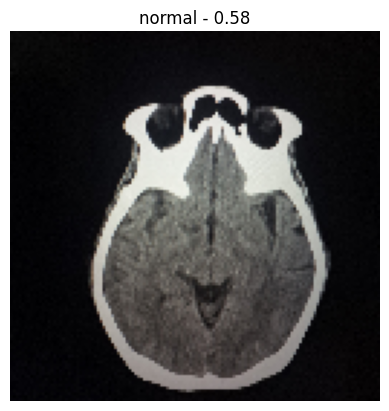

In [128]:
predict_image('dataset/sakit/20250602_150807.jpg')

predict_image('dataset/normal/20250616_145956.jpg')